In [51]:
#to install with pip tensorflow i had to change the registry value for longpaths.
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import   LabelEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

In [52]:
df=pd.read_csv('data/Results_TTM.csv',sep=";",header=0)
df=df.drop(columns=["Step status","Current trend","Torque rate min","Torque rate max","Torque rate trend","CVILOGIX","Identifier6","Identifier7","Identifier8","Identifier9","Identifier10","Second transducer torque deviation","Second transducer angle deviation","Result type","Pulse counter","Angle offset","AO torque rate"])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (45,46,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [53]:
df=df[['Result status','Result number','Time result','Pset ID','Step ID','Error Code', 'Torque min','Torque','Torque max','Angle min','Angle','Angle max','Pset name','VIN','Identifier1','Identifier2','Identifier3','Identifier4','Identifier5']]

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Result status  400000 non-null  object 
 1   Result number  400000 non-null  int64  
 2   Time result    400000 non-null  object 
 3   Pset ID        399901 non-null  float64
 4   Step ID        399901 non-null  float64
 5   Error Code     22688 non-null   object 
 6   Torque min     399901 non-null  float64
 7   Torque         400000 non-null  float64
 8   Torque max     399901 non-null  float64
 9   Angle min      399901 non-null  float64
 10  Angle          400000 non-null  float64
 11  Angle max      399901 non-null  float64
 12  Pset name      399901 non-null  object 
 13  VIN            172013 non-null  object 
 14  Identifier1    172013 non-null  object 
 15  Identifier2    170608 non-null  object 
 16  Identifier3    168406 non-null  object 
 17  Identifier4    13920 non-null

Rename de columns to avoid spaces.

In [55]:
df=df.rename(columns={"Result status":"Result_status","Result number":"Result_number","Pset ID":"Pset_ID","Step ID":"Step_ID","Torque min":"Torque_min","Torque max":"Torque_max","Angle min":"Angle_min","Angle max":"Angle_max","Pset name":"Pset_name",'Error code':'Error_code','Result_status':'Result_status','Time result':'Time_result'})


Vamos a mirar a ver cuales de los pares son NOK, filtramos la columna de resultado

In [56]:
df_nok=df[df['Result_status'].str.contains("NOK")]
df_nok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22568 entries, 34 to 399969
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Result_status  22568 non-null  object 
 1   Result_number  22568 non-null  int64  
 2   Time_result    22568 non-null  object 
 3   Pset_ID        22568 non-null  float64
 4   Step_ID        22568 non-null  float64
 5   Error Code     22568 non-null  object 
 6   Torque_min     22568 non-null  float64
 7   Torque         22568 non-null  float64
 8   Torque_max     22568 non-null  float64
 9   Angle_min      22568 non-null  float64
 10  Angle          22568 non-null  float64
 11  Angle_max      22568 non-null  float64
 12  Pset_name      22568 non-null  object 
 13  VIN            9477 non-null   object 
 14  Identifier1    9477 non-null   object 
 15  Identifier2    9289 non-null   object 
 16  Identifier3    9301 non-null   object 
 17  Identifier4    1431 non-null   object 
 18  Iden

In [57]:
df_nok['Pset_name'].head()
df_nok[['Pset_name','Result_status']].groupby(by='Pset_name').count().sort_values(by=['Result_status'], ascending=False)

,Result_status
Pset_name,
Seat frame front_35Nm,1109
Armrests 28Nm,990
Slides 22Nm TX40 ISC,920
Cross angle back - Swivel_22Nm,885
Seat frame assy_35Nm_2x59-2_ISC,877
...,...
Backrest segment 22Nm ISC_A_BAU,1
Poka Yoke Check_6xxx,1
Torque_35Nm,1


Vemos que hay un resultado POKA YOKE, es un resultado NOK forzado que se hace para comprobar la herramientas. hay que quitarlos de la muestra.

In [58]:
df = df[~df["Pset_name"].str.contains("Poka",na=False)]

In [59]:
df.astype({'Time_result': 'datetime64[ns, US/Eastern]'}).dtypes

Result_status                        object
Result_number                         int64
Time_result      datetime64[ns, US/Eastern]
Pset_ID                             float64
Step_ID                             float64
Error Code                           object
Torque_min                          float64
Torque                              float64
Torque_max                          float64
Angle_min                           float64
Angle                               float64
Angle_max                           float64
Pset_name                            object
VIN                                  object
Identifier1                          object
Identifier2                          object
Identifier3                          object
Identifier4                          object
Identifier5                          object
dtype: object

creamos una columna nueva la columna de resultado que contiene los tesxtos "NOK" y "OK" en valores numericos.

In [60]:
df['Resultbin']=df['Result_status']=='OK'

In [61]:
df.head()


,Result_status,Result_number,Time_result,Pset_ID,Step_ID,Error Code,Torque_min,Torque,Torque_max,Angle_min,Angle,Angle_max,Pset_name,VIN,Identifier1,Identifier2,Identifier3,Identifier4,Identifier5,Resultbin
0,OK,613029,2020-12-10 23:59:12.0,10.0,1.0,NaN,18.0,20.126,22.0,3.0,40.213,100.0,Fixation screw_(60895R01)_20Nm_1x64-5_IF,NaN,NaN,NaN,NaN,NaN,NaN,True
1,OK,613028,2020-12-10 23:59:08.0,9.0,1.0,NaN,18.0,20.090,22.0,5.0,40.369,100.0,Fixation screw_(318327B01)_20Nm_1x64-4_I,NaN,NaN,NaN,NaN,NaN,NaN,True
2,OK,613027,2020-12-10 23:58:56.0,3.0,1.0,NaN,20.0,22.219,24.0,5.0,40.389,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True
3,OK,613026,2020-12-10 23:58:48.0,3.0,1.0,NaN,20.0,22.138,24.0,5.0,33.650,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True
4,OK,613025,2020-12-10 23:58:41.0,3.0,1.0,NaN,20.0,22.073,24.0,5.0,43.830,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True


Aun tenemos columnas que no van a aportar nada a nuestro modelo.

In [62]:
dfX=df.drop(columns={'Result_status','Result_number','Time_result','Pset_ID','Identifier4','Identifier5','Identifier2','Error Code','Torque','Angle'})

con df.info() vamos a ver cuantas columnas contienen resultados nulos y vamos a hacer que toda la muestra tenga columnas con datos que podamos utilizar.
Con esta accion podemos hacer que nuestro modelo posterior no sea tan bueno prediciendo los resultados de las columnas que tienen nulls.

In [63]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398943 entries, 0 to 399999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Step_ID      398844 non-null  float64
 1   Torque_min   398844 non-null  float64
 2   Torque_max   398844 non-null  float64
 3   Angle_min    398844 non-null  float64
 4   Angle_max    398844 non-null  float64
 5   Pset_name    398844 non-null  object 
 6   VIN          172013 non-null  object 
 7   Identifier1  172013 non-null  object 
 8   Identifier3  168406 non-null  object 
 9   Resultbin    398943 non-null  bool   
dtypes: bool(1), float64(5), object(4)
memory usage: 30.8+ MB


Vamos a echar un vistazo a los valores que vamos a quitar. porque se va a reducir mucho la muestra.

In [64]:

df_NANs=dfX[['Pset_name','Identifier1','Identifier3','Resultbin']]
df_NANs.loc[df_NANs['Identifier1'].isnull(),'value_is_NaN'] = 'Yes'
df_NANs.loc[df_NANs['Identifier1'].notnull(), 'value_is_NaN'] = 'No'
df_NANs = df_NANs[df_NANs["value_is_NaN"].str.contains("Yes",na=False)]
df_NANs[['Pset_name','Resultbin']].groupby(by='Pset_name').count().sort_values(by='Resultbin',ascending=False)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Resultbin
Pset_name,
Sliders 22Nm_4x65-4_ISC,19342
Backrest_40Nm,10887
Seat frame assy_35Nm_2x59-2_ISC,10709
Bearing inclination cap_22Nm_2x59-1_ISC,10022
Inner carrier_22Nm_2x59-3_ISC,9927
...,...
Cushion slides_WOOD_10Nm+-2,80
Embocar Profiles 30Nm ISC,77
Slides 22Nm TX40 ISC,6


Estamos perdiendo valores OK y NOK de las líneas NTS1 y NTS2 que no guardan valueIdentifiers. Es decir que el analisis se va a focalizar en las líneas:
1. ALter BAU
2. Alter BUS
3. Tapizado NTS1
4. Tapizado NTS2
5. NTS1 BAU
Vamos a proceder a eliminar los resultados nulos del Df

In [65]:
dfX=dfX.dropna()
dfX = dfX[pd.to_numeric(dfX['Identifier3'],errors='coerce').notna()]
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168002 entries, 10 to 399996
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Step_ID      168002 non-null  float64
 1   Torque_min   168002 non-null  float64
 2   Torque_max   168002 non-null  float64
 3   Angle_min    168002 non-null  float64
 4   Angle_max    168002 non-null  float64
 5   Pset_name    168002 non-null  object 
 6   VIN          168002 non-null  object 
 7   Identifier1  168002 non-null  object 
 8   Identifier3  168002 non-null  object 
 9   Resultbin    168002 non-null  bool   
dtypes: bool(1), float64(5), object(4)
memory usage: 13.0+ MB


Observamos ahora que tenemos 168.002 registros no nulos con los que podemos elaborar un modelo. vamos a ver el porcentaje de aprietes NOK totales.  

In [66]:
dfX[['Resultbin','Step_ID']].groupby(by='Resultbin').count()

,Step_ID
Resultbin,
False,9236
True,158766


In [67]:
OKS = len(df[df["Result_status"].str.contains("OK",na=False)])
NOKS=len(df[df["Result_status"].str.contains("NOK",na=False)])
NOKS/OKS

0.05391998355654818

Tenemos un 5% de pares malos en este conjunto de datos.

vamos a quitar algunos ok para que la red neuronal aprenda mejor:

In [68]:
dfX = dfX.drop(dfX[dfX['Resultbin'] == True].sample(frac=.4, random_state=101).index)
#Quito el 40 % de los resultados OK  de DFX
dfX[['Resultbin','Step_ID']].groupby(by='Resultbin').count()

,Step_ID
Resultbin,
False,9236
True,95260


In [69]:
enc=LabelEncoder()
dfX=df[['Torque_min','Torque_max','Angle_min','Angle_max','Pset_name',	'Identifier1','Identifier3','Resultbin']].dropna()
dfX['Identifier3'] = df['Identifier3'].astype('string',copy=False)
dfX['Pset_name_cat'] = enc.fit_transform(dfX['Pset_name'])
dfX['Modelo'] = enc.fit_transform(dfX['Identifier1'])
dfX[['Identifier3','Resultbin']].groupby(by="Identifier3").count()
dfX[dfX['Identifier3'].apply(lambda x: x.isnumeric())]
dfX['Trabajador'] = enc.fit_transform(dfX['Identifier3'])


In [70]:
dfX.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 168021 entries, 10 to 399996
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Torque_min     168021 non-null  float64
 1   Torque_max     168021 non-null  float64
 2   Angle_min      168021 non-null  float64
 3   Angle_max      168021 non-null  float64
 4   Pset_name      168021 non-null  object 
 5   Identifier1    168021 non-null  object 
 6   Identifier3    168021 non-null  string 
 7   Resultbin      168021 non-null  bool   
 8   Pset_name_cat  168021 non-null  int32  
 9   Modelo         168021 non-null  int32  
 10  Trabajador     168021 non-null  int32  
dtypes: bool(1), float64(4), int32(3), object(2), string(1)
memory usage: 12.3+ MB


Ok, ahora vamos a dejar el df solo con las columnas que nos interesan y empezaremos a preparar nuestro modelo.

In [71]:
dfX["Resultbin"] = dfX["Resultbin"].astype(int)
y=np.array(dfX["Resultbin"])
dfX=dfX.drop(columns={'Resultbin','Pset_name','Identifier1','Identifier3','Angle_min'})
X=dfX.values
print(y, X)



[1 1 1 ... 1 1 1] [[  14.   18. 3000.   70.  115.   38.]
 [  30.   40. 3000.   24.  115.   38.]
 [  30.   40. 3000.   36.  115.   38.]
 ...
 [  30.   40.  350.   27.   41.   89.]
 [  20.   24.  220.   21.   41.   42.]
 [  20.   24.  220.   21.   41.   42.]]


In [72]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.utils import shuffle
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs available:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

label=np.array(y)
sample=np.array(X)

print(label.shape,sample.shape)



Num GPUs available: 1
(168021,) (168021, 6)


In [73]:
label,sample =shuffle(label,sample)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_samples= scaler.fit_transform(sample) #fit transform does not accept 1D data so we reshape the scaled train samples to be 2D


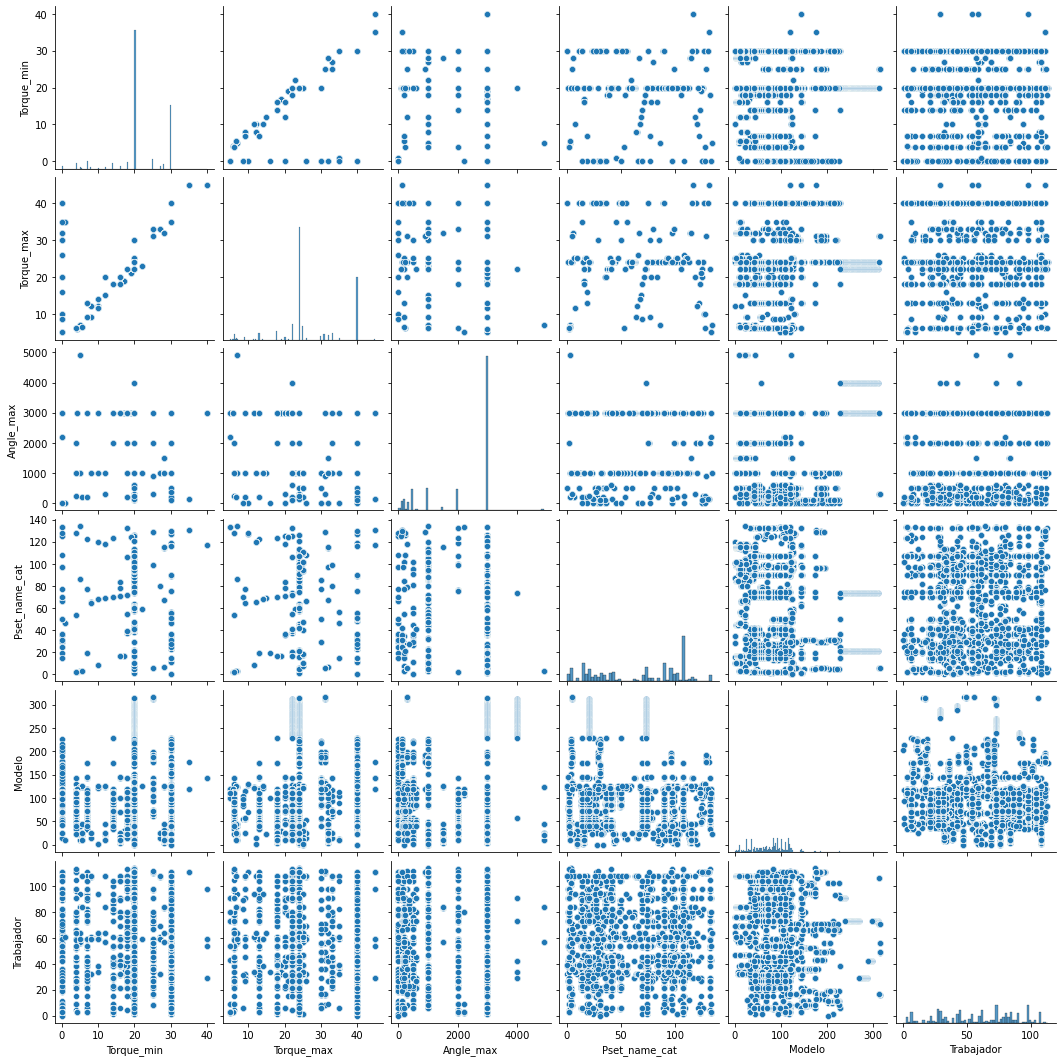

In [74]:
import seaborn as sns
sns.pairplot (dfX)

In [75]:
print(y, X)
print(y.shape,X.shape)

[1 1 1 ... 1 1 1] [[  14.   18. 3000.   70.  115.   38.]
 [  30.   40. 3000.   24.  115.   38.]
 [  30.   40. 3000.   36.  115.   38.]
 ...
 [  30.   40.  350.   27.   41.   89.]
 [  20.   24.  220.   21.   41.   42.]
 [  20.   24.  220.   21.   41.   42.]]
(168021,) (168021, 6)


In [76]:
print(label,scaled_samples)
print(label.shape,scaled_samples.shape)

[1 1 1 ... 1 1 1] [[0.5        0.475      0.6122449  0.79850746 0.37025316 0.05263158]
 [0.75       0.875      0.6122449  0.67164179 0.4556962  0.39473684]
 [0.5        0.475      0.6122449  0.79850746 0.37025316 0.05263158]
 ...
 [0.5        0.625      0.10204082 0.21641791 0.37974684 0.07017544]
 [0.75       0.875      0.6122449  0.26865672 0.31962025 0.27192982]
 [0.5        0.425      0.6122449  0.30597015 0.15822785 0.64035088]]
(168021,) (168021, 6)


In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_samples, label, test_size=0.33, random_state=42)


In [78]:
print(X_test.shape, X_train.shape)
print(y_test.shape,y_train.shape)

(55447, 6) (112574, 6)
(55447,) (112574,)


In [79]:
model = Sequential([
    Dense(units=16,input_shape=[len(dfX.keys())],activation='relu'),
    Dense(units=32,activation='relu'),
    Dense(units=2,activation='softmax')  # dos clases, par ok par nok.
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________


In [80]:
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# voy a cambiar el optimizer a ver si mejora 

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy
opt = SGD(learning_rate=0.01)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics= ['accuracy'])

In [81]:
print(len(dfX.keys()))

6


In [82]:
model.fit(x=X_train,y=y_train, validation_split=0.1,batch_size=10,epochs=10,shuffle=True, verbose=2)

Epoch 1/10
10132/10132 - 35s - loss: 0.2107 - accuracy: 0.9440 - val_loss: 0.2032 - val_accuracy: 0.9460 - 35s/epoch - 3ms/step
Epoch 2/10
10132/10132 - 34s - loss: 0.2027 - accuracy: 0.9454 - val_loss: 0.2019 - val_accuracy: 0.9460 - 34s/epoch - 3ms/step
Epoch 3/10
10132/10132 - 32s - loss: 0.2018 - accuracy: 0.9454 - val_loss: 0.2016 - val_accuracy: 0.9460 - 32s/epoch - 3ms/step
Epoch 4/10
10132/10132 - 33s - loss: 0.2012 - accuracy: 0.9454 - val_loss: 0.2013 - val_accuracy: 0.9460 - 33s/epoch - 3ms/step
Epoch 5/10
10132/10132 - 33s - loss: 0.2006 - accuracy: 0.9454 - val_loss: 0.2005 - val_accuracy: 0.9460 - 33s/epoch - 3ms/step
Epoch 6/10
10132/10132 - 33s - loss: 0.2001 - accuracy: 0.9454 - val_loss: 0.1999 - val_accuracy: 0.9460 - 33s/epoch - 3ms/step
Epoch 7/10
10132/10132 - 40s - loss: 0.1994 - accuracy: 0.9454 - val_loss: 0.1993 - val_accuracy: 0.9461 - 40s/epoch - 4ms/step
Epoch 8/10
10132/10132 - 41s - loss: 0.1987 - accuracy: 0.9454 - val_loss: 0.1987 - val_accuracy: 0.9460

In [83]:
precictions=model.predict(x=X_test.tolist(),batch_size=10,verbose=0)
print(precictions)

[[0.08756748 0.9124325 ]
 [0.03343114 0.9665689 ]
 [0.04619899 0.953801  ]
 ...
 [0.08714651 0.91285354]
 [0.08471712 0.9152829 ]
 [0.04797322 0.9520268 ]]


Plot confusion matrix

In [84]:
rounded_predictions=np.argmax(precictions,axis=-1)

In [85]:

import numpy as np
import  itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[   53  3039]
 [    0 52355]]


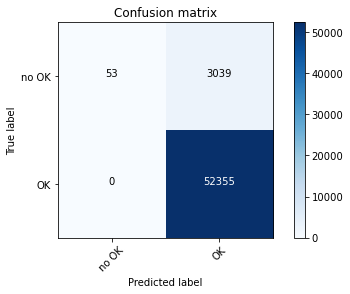

In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test,y_pred=rounded_predictions)
cm_plot_labels=['no OK','OK']
plot_confusion_matrix (cm,cm_plot_labels,title='Confusion matrix')
plt.show()

Me pasa lo mismo que con el modelo de regresion lineal => hay que tratar los datos para incrementar el numero de resultados NOK porcentualmente sobre el total de datos.

### confusion matrix logistic regresion in TTM_Pamplona

[   12,  2308]


[    0, 39686]
con todo el dataframe  Neural Network % nok predicted good = 0,005
tras reducir el número de pares Ok un 40% me sale la siguiente cm: Neural Network % nok predicted good 0.027

[   80  2905]


[    0 52462]

quitando el angulo minimo. Neural Network % nok predicted good: 0.017

[   53  3039]


[    0 52355]

vamos a volver a añadir  los pares ok a ver que hace but still i am too far


In [88]:
porcentaje_pares_LR=12/(12+2308)
porcentaje_pares_NN=cm[0,0]/(cm[0,0]+cm[0,1])

print("Logistic regresion % nok predicted as NOK: "+str(round(porcentaje_pares_LR,3)))
print("Neural Network % nok predicted NOK: "+str(round(porcentaje_pares_NN,3)))

Logistic regresion % nok predicted as NOK: 0.005
Neural Network % nok predicted NOK: 0.017


Es incluso **peor** voy a quitar el angulo minimo que es casi siempre cero y me no aporta nada.